### In this homework assigment, you are required to apply the neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation. Please follow the instructions detailed below. 

Step 1: Generate an offline dataset. Consider the `CartPole` example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

Step 2: Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies. 

* To combine FQI with neural networks, we consider using the [`MLPregressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We may set the maximum number of iterations to 500. 

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward. 

Step 3: Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results. 

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import copy
from sklearn.neural_network import MLPRegressor

#### Generate offline dataset
In Fitted Q-iteration, the offline dataset was generated and kept static. There will be no further interaction with the environment during learning. Each set of data comprises 4 components: $(s,a,s^{'},r)$, where $(s,a)$ is the current state-action pair, $r$ represents the immediate reward and $s^{'}$ denotes the successor state. Next I will generate the dataset by following the required mixed policy, for 100 episodes. 

1. I will generate two seperate datasets which correspondes to the action space(left and right), each state(row) in the two datasets will be followed by its next state. In such a setting, we can put all observations into a single list and rows [0,2,4,6...] corresponde to the current states, while [1,3,5,7...] corresponde to the next states. This also ensures the independence of states among different episodes, say that the terminal state of one episode will never be in the current state list.

2. Since the TD target for the terminal state is simply the immediate reward which is 0. For each state, I will append a 1 at the end for non-terminal states and 0 for terminal states. So it is easy to obtain the index of the terminal state.

In [2]:
def mix_policy(angle):
    if np.random.binomial(1, 0.5):
        return 0 if (angle < 0) else 1
    else:
        return np.random.binomial(1, 0.5)

In [3]:
env = gym.make('CartPole-v0')
env.reset()
episodes = 100
left_data = []
right_data = []

for i in range(episodes):
    obs = env.reset()
    done = False
    
    while not done:
        a = mix_policy(obs[2])
        old_obs = copy.deepcopy(obs)
        obs, r, done, info = env.step(a)
        
        old_tup = np.append(old_obs, r)
        next_tup = np.append(obs, 1)
        # for the terminal state, append 0, otherwise append 1.
        if a: 
            right_data.append(old_tup)
            right_data.append(next_tup)
            if done:
                right_data.append(np.append(obs, 0))
                right_data.append(next_tup)
        else:
            left_data.append(old_tup)
            left_data.append(next_tup)
            if done:
                left_data.append(np.append(obs, 0))
                left_data.append(next_tup)
            
left_data = np.array(left_data)
right_data = np.array(right_data)

#### Implementation of NFQ
To implement NFQ algorithm, we can treat $(s,a,s^{'},r)$ as predictors and $y_i=r(s_i,a_i)+\gamma \max_{a^{'}_i}Q_w(s^{'}_i, a^{'}_i)$ as the responses, and then solve the optimisation problem $\arg\min_{w}\frac{1}{2}\sum_i||Q_w(s_i,a_i)-y_i||^2$ by using gradient descent. Since our dataset is static and in NFQ we sample the full gradient, so $\sum_i||Q_w(s_i,a_i)-y_i||^2$ approximates to the real MSE when the dataset is large enough.

1. The predictors are static, but we need to update the model and predict on the input to obtain new responses. 

2. For each episode during traninig, it represents a policy. So we will have 20 models for each $\gamma$. For each model, it comprises two seperate models for each action. I will use a dictionary to contain 60 policies collected from training.

3. When updating models during 20 iterations, there are two ways:

    I. Initilise a neural network at the beginning and use the same network for later fitting.
    
    II. Initilise new neural network for every iteration, but with updated responses.
  

In [16]:
model_collector = {}
gamma_list = [0.95, 0.99, 1.]
for gamma in gamma_list:
    for ite in range(1,21):
        model_collector[(gamma, ite)] = None

In [17]:
#Type-1 NFQ: Use the same NNs for all fitting.
def NFQ1(data_0, data_1, gamma, episodes=20):
    model_0 = MLPRegressor(max_iter=500)
    model_1 = MLPRegressor(max_iter=500)
    
    X_0 = data_0[::2, :-1]
    next_x0 = data_0[1::2, :-1]
    y_0 = data_0[::2, -1]
    ind_0 = np.argwhere(next_x0[:, -1]==0).squeeze()#the index of terminal state
    
    X_1 = data_1[::2, :-1]
    next_x1 = data_1[1::2, :-1]
    y_1 = data_1[::2, -1]
    ind_1 = np.argwhere(next_x1[:, -1]==0).squeeze()
    
    for i in range(episodes):
        model_0.fit(X_0, y_0) #use the same network to fit the data, can learn previous experiences
        model_1.fit(X_1, y_1)
        models = [model_0, model_1]
        
        model_collector[(gamma, i+1)] = copy.deepcopy(models)
        
        maxQ_0 = np.maximum(model_0.predict(next_x0), model_1.predict(next_x0))
        maxQ_0[ind_0] = 0 #when next states are terminal, set Q=0
        
        maxQ_1 = np.maximum(model_0.predict(next_x1), model_1.predict(next_x1))
        maxQ_1[ind_1] = 0
        
        y_0 = data_0[::2, -1] + gamma * maxQ_0
        y_1 = data_1[::2, -1] + gamma * maxQ_1

In [6]:
#Type-2 NFQ: Initilise new NNs at every iteration
def NFQ2(data_0, data_1, gamma, episodes=20):
    model_0 = MLPRegressor(max_iter=500)
    model_1 = MLPRegressor(max_iter=500)
    
    X_0 = data_0[::2, :-1]
    next_x0 = data_0[1::2, :-1]
    y_0 = data_0[::2, -1]
    ind_0 = np.argwhere(next_x0[:, -1]==0).squeeze()#the index of terminal state
    
    X_1 = data_1[::2, :-1]
    next_x1 = data_1[1::2, :-1]
    y_1 = data_1[::2, -1]
    ind_1 = np.argwhere(next_x1[:, -1]==0).squeeze()
    
    for i in range(episodes):
        model_0.fit(X_0, y_0)
        model_1.fit(X_1, y_1)
        models = [model_0, model_1]
        
        model_collector[(gamma, i+1)] = copy.deepcopy(models)
        
        maxQ_0 = np.maximum(model_0.predict(next_x0), model_1.predict(next_x0))
        maxQ_0[ind_0] = 0 #when next states are terminal, set Q=0
        
        maxQ_1 = np.maximum(model_0.predict(next_x1), model_1.predict(next_x1))
        maxQ_1[ind_1] = 0
        
        y_0 = data_0[::2, -1] + gamma * maxQ_0
        y_1 = data_1[::2, -1] + gamma * maxQ_1
        
        model_0 = MLPRegressor(max_iter=500)#initilise new network for each iteration
        model_1 = MLPRegressor(max_iter=500)

In [18]:
for gamma in gamma_list:
    NFQ1(left_data, right_data, gamma)

#### Offline policy evaluation
To evaluate the expected return for each policy, we need to generate 1000 episodes and then calculate the total rewards for each episode under the policy, finally average over 1000 episodes to obtain the expected return. Since in the above I defined two ways of representing NFQ, I will produce two figures as well.

In [19]:
reward_matrix = np.zeros((3,20))

def get_reward(policy, episodes=1000):
    rewards = 0.0
    for i in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            Q0 = policy[0].predict(np.atleast_2d(obs))
            Q1 = policy[1].predict(np.atleast_2d(obs))
            a = 0 if Q0>Q1 else 1 #choose the optimal action
            obs, r, done, info = env.step(a)
            rewards += r
    return rewards/episodes

In [20]:
for i in range(3):
    for j in range(20):
        gamma = gamma_list[i]
        reward_matrix[i][j] = get_reward(model_collector[(gamma, j+1)])

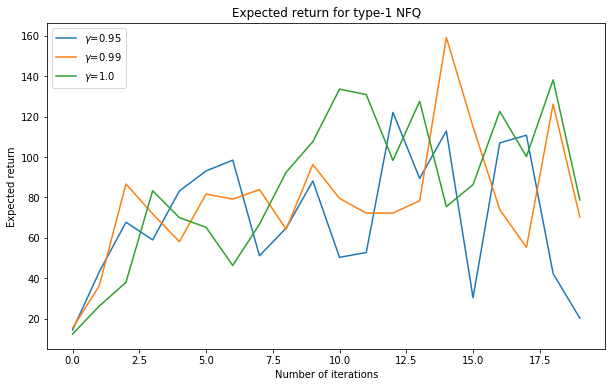

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(reward_matrix[0], label="$\gamma$=0.95")
ax.plot(reward_matrix[1], label="$\gamma$=0.99")
ax.plot(reward_matrix[2], label="$\gamma$=1.0")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Expected return")
ax.set_title("Expected return for type-1 NFQ")
ax.legend()
plt.show()

For the type-1 NFQ, the results are volatile but the trend of expected return goes up as the number of iterations increases. It is not obvious enough to determine which $\gamma$ value should be the best just through this plot, where limited data and only 20 iterations were applied. Roughly, $\gamma=0.95$ may have poorer curves compared to the other two from the above figure.  

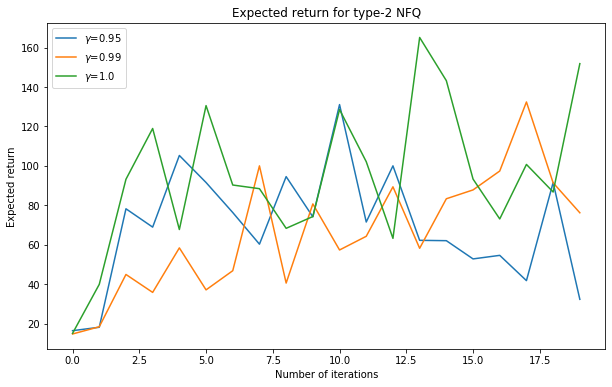

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(reward_matrix[0], label="$\gamma$=0.95")
ax.plot(reward_matrix[1], label="$\gamma$=0.99")
ax.plot(reward_matrix[2], label="$\gamma$=1.0")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Expected return")
ax.set_title("Expected return for type-2 NFQ")
ax.legend()
plt.show()

In this way, it seems it is more volatile than the type-1 NFQ and obtain less expected return. However, the trend of results is  increasing as well, this defends the correctness of the algorithm. Not convincingly, $\gamma=0.95$ seems have slightly worse performances than the other two $\gamma$ values for both types of NFQ.